In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset train & test data

This Task is (SEB VS NEVUS) - Task 1

In [3]:
#set title for saving model correctly!!!
title = "seb_vs_nev_no_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#initializing the model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [10]:
#Adding additional layer on top of ViT model
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)       #Configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                         #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [13]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [14]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

#Function for model evaluation
def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # Calculating ROC score

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)           #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')      #Calculating precision

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/content/drive/MyDrive/msc_project/train_splited"
test_dir = "/content/drive/MyDrive/msc_project/test_splited"

In [16]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [17]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [18]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1300 validated image filenames belonging to 2 classes.
Found 326 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.8614 - accuracy: 0.5538
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_1.hdf5
13/13 [==============================] - 91s 1s/step - loss: 0.8614 - accuracy: 0.5538 - val_loss: 0.6320 - val_accuracy: 0.8250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.7851 - accuracy: 0.5615
Epoch 2: val_accuracy did not improve from 0.82500
13/13 [==============================] - 9s 652ms/step - loss: 0.7851 - accuracy: 0.5615 - val_loss: 0.7040 - val_accuracy: 0.6500 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rat

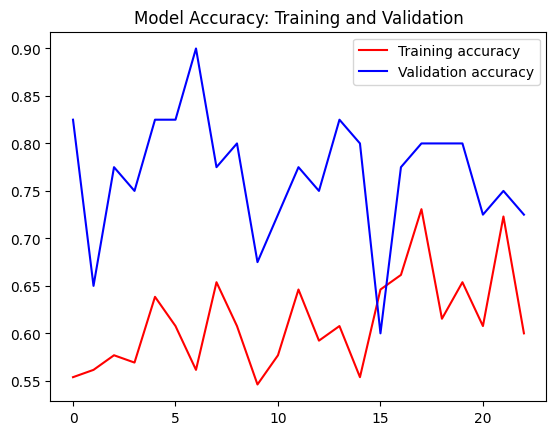

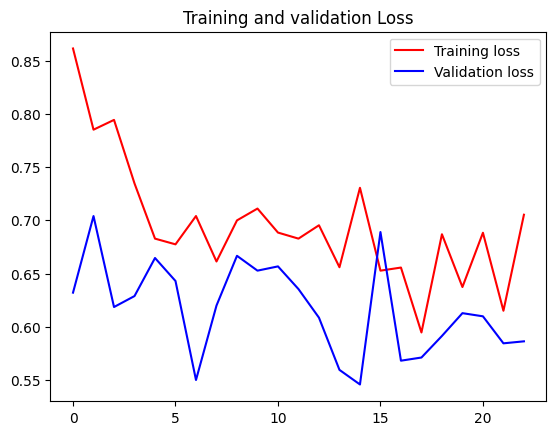

<Figure size 640x480 with 0 Axes>

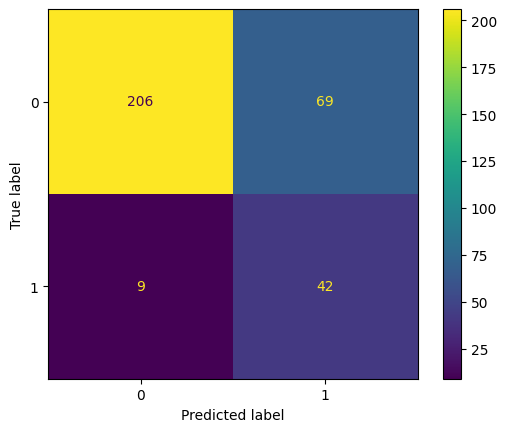


               precision    recall  f1-score   support

           0       0.96      0.75      0.84       275
           1       0.38      0.82      0.52        51

    accuracy                           0.76       326
   macro avg       0.67      0.79      0.68       326
weighted avg       0.87      0.76      0.79       326

Sensitivity: 0.824 Specificity: 0.749 Precision: 0.867 ROC_AUC_SCORE: 0.883



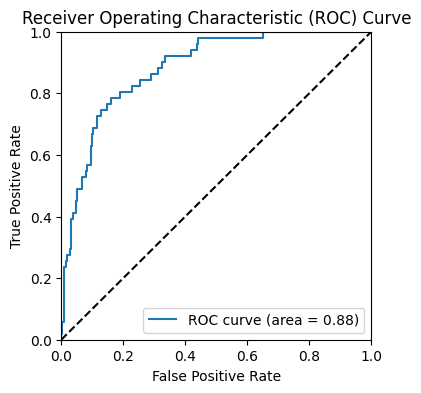

Validation complete...
Traning for Fold: 2
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.6786
Epoch 1: val_accuracy improved from -inf to 0.65000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_2.hdf5
14/14 [==============================] - 68s 1s/step - loss: 0.6672 - accuracy: 0.6786 - val_loss: 0.7549 - val_accuracy: 0.6500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.6214
Epoch 2: val_accuracy improved from 0.65000 to 0.77500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_2.hdf5
14/14 [==============================] - 14s 1s/step - loss: 0.6847 - accuracy:

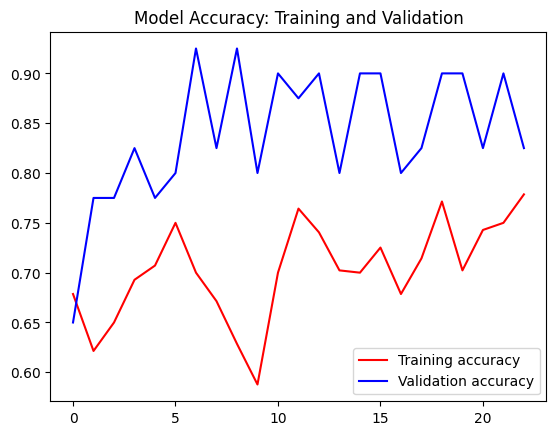

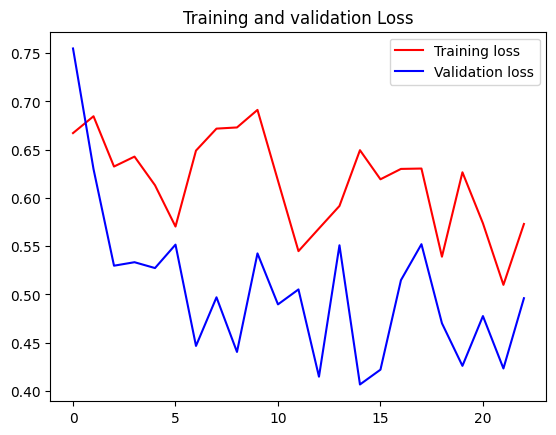

<Figure size 640x480 with 0 Axes>

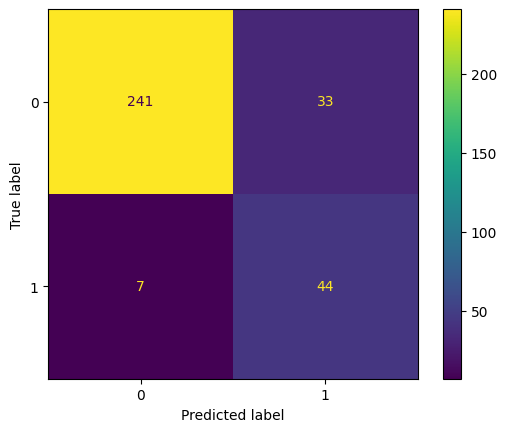


               precision    recall  f1-score   support

           0       0.97      0.88      0.92       274
           1       0.57      0.86      0.69        51

    accuracy                           0.88       325
   macro avg       0.77      0.87      0.81       325
weighted avg       0.91      0.88      0.89       325

Sensitivity: 0.863 Specificity: 0.88 Precision: 0.909 ROC_AUC_SCORE: 0.943



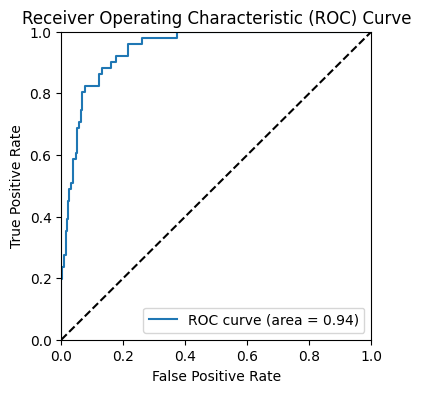

Validation complete...
Traning for Fold: 3
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.6571
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_3.hdf5
14/14 [==============================] - 66s 1s/step - loss: 0.6185 - accuracy: 0.6571 - val_loss: 0.3978 - val_accuracy: 0.9500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.6714
Epoch 2: val_accuracy did not improve from 0.95000
14/14 [==============================] - 8s 553ms/step - loss: 0.6142 - accuracy: 0.6714 - val_loss: 0.4539 - val_accuracy: 0.8750 - lr: 2.0000e-05

Epoch 3: LearningRateSchedul

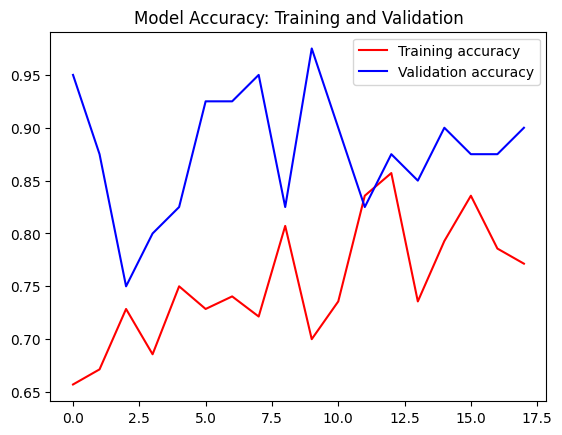

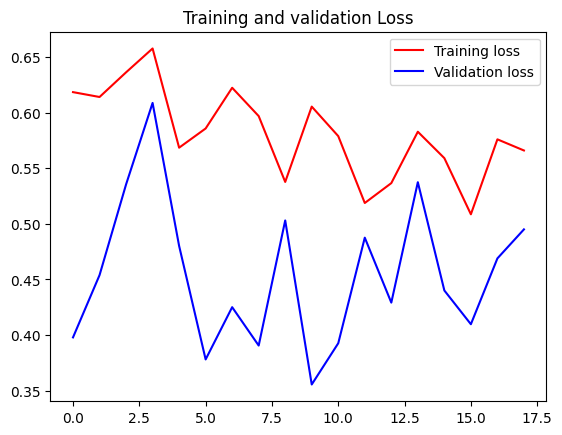

<Figure size 640x480 with 0 Axes>

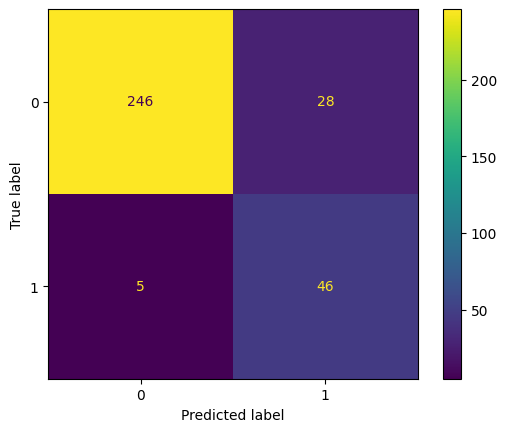


               precision    recall  f1-score   support

           0       0.98      0.90      0.94       274
           1       0.62      0.90      0.74        51

    accuracy                           0.90       325
   macro avg       0.80      0.90      0.84       325
weighted avg       0.92      0.90      0.91       325

Sensitivity: 0.902 Specificity: 0.898 Precision: 0.924 ROC_AUC_SCORE: 0.949



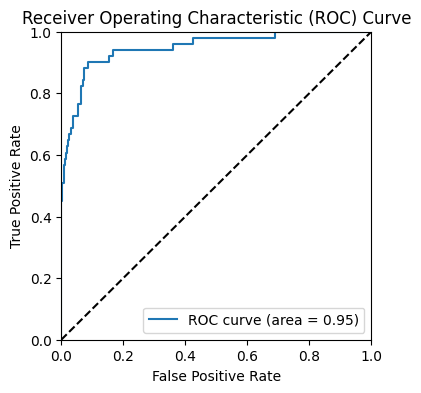

Validation complete...
Traning for Fold: 4
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.7786
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_4.hdf5
14/14 [==============================] - 69s 1s/step - loss: 0.5567 - accuracy: 0.7786 - val_loss: 0.3626 - val_accuracy: 0.9500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.7429
Epoch 2: val_accuracy improved from 0.95000 to 1.00000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_4.hdf5
14/14 [==============================] - 9s 687ms/step - loss: 0.5879 - accurac

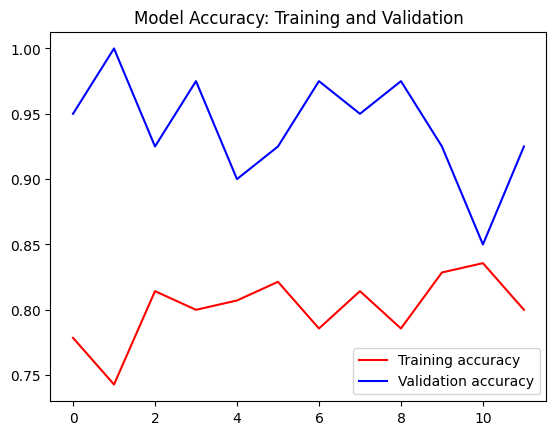

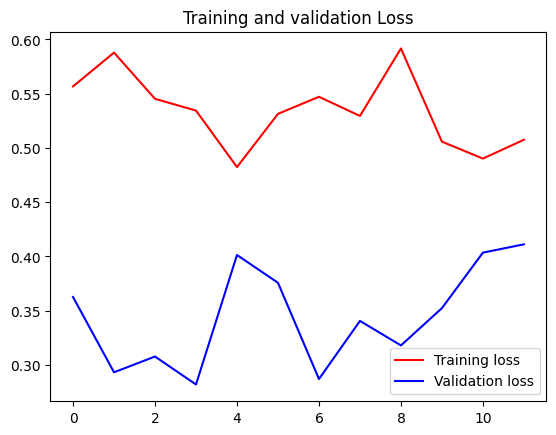

<Figure size 640x480 with 0 Axes>

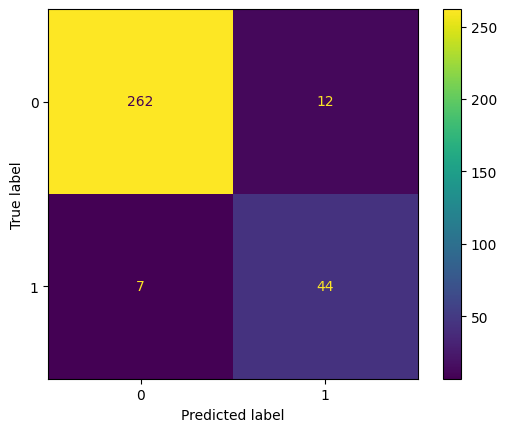


               precision    recall  f1-score   support

           0       0.97      0.96      0.97       274
           1       0.79      0.86      0.82        51

    accuracy                           0.94       325
   macro avg       0.88      0.91      0.89       325
weighted avg       0.94      0.94      0.94       325

Sensitivity: 0.863 Specificity: 0.956 Precision: 0.944 ROC_AUC_SCORE: 0.971



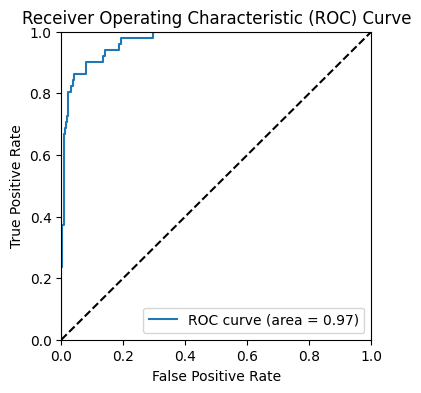

Validation complete...
Traning for Fold: 5
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7929
Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_5.hdf5
14/14 [==============================] - 75s 2s/step - loss: 0.5783 - accuracy: 0.7929 - val_loss: 0.3657 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.7714
Epoch 2: val_accuracy improved from 0.92500 to 1.00000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_5.hdf5
14/14 [==============================] - 11s 821ms/step - loss: 0.5671 - accura

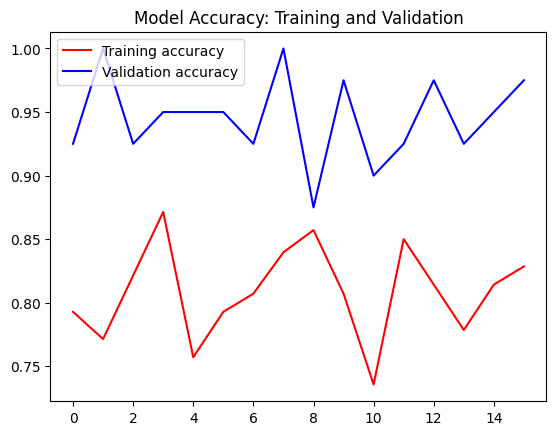

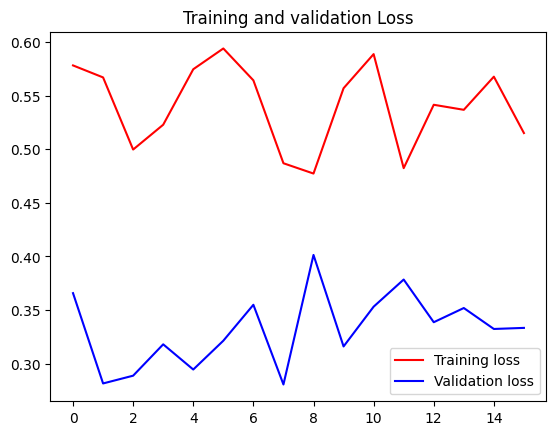

<Figure size 640x480 with 0 Axes>

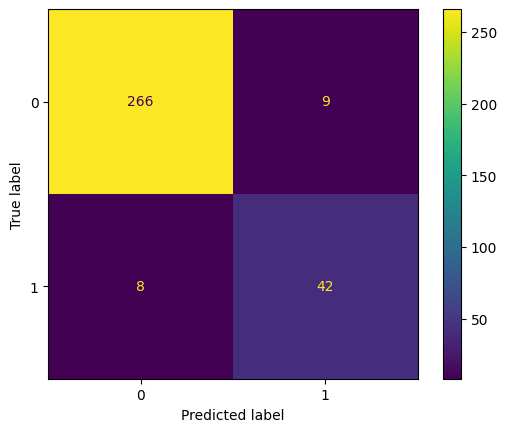


               precision    recall  f1-score   support

           0       0.97      0.97      0.97       275
           1       0.82      0.84      0.83        50

    accuracy                           0.95       325
   macro avg       0.90      0.90      0.90       325
weighted avg       0.95      0.95      0.95       325

Sensitivity: 0.84 Specificity: 0.967 Precision: 0.948 ROC_AUC_SCORE: 0.969



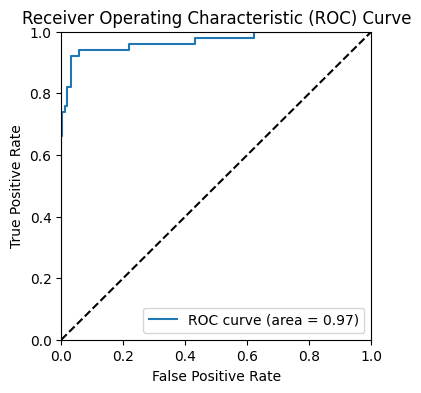

Validation complete...


In [19]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)


    #Evaluting the model using validation data with shuffle = false
    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [20]:
test_dir

'/content/drive/MyDrive/msc_project/test_splited'

In [21]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 483 images belonging to 2 classes.


Test using model 1
483/483 [==============================] - 35s 72ms/step


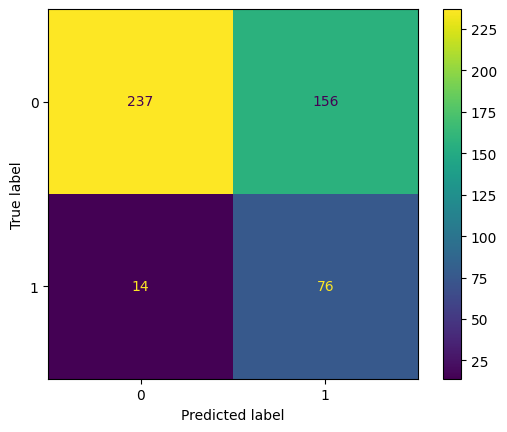


               precision    recall  f1-score   support

           0       0.94      0.60      0.74       393
           1       0.33      0.84      0.47        90

    accuracy                           0.65       483
   macro avg       0.64      0.72      0.60       483
weighted avg       0.83      0.65      0.69       483

Sensitivity: 0.844 Specificity: 0.603 Precision: 0.829 ROC_AUC_SCORE: 0.824



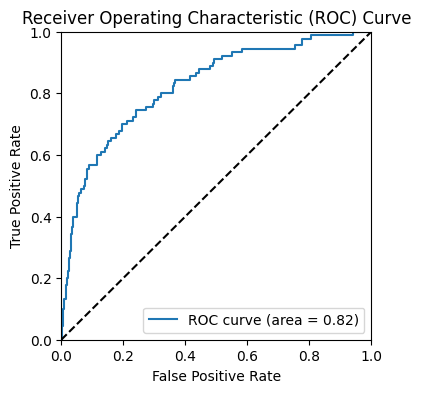

Testing Complete
Test using model 2
483/483 [==============================] - 23s 47ms/step


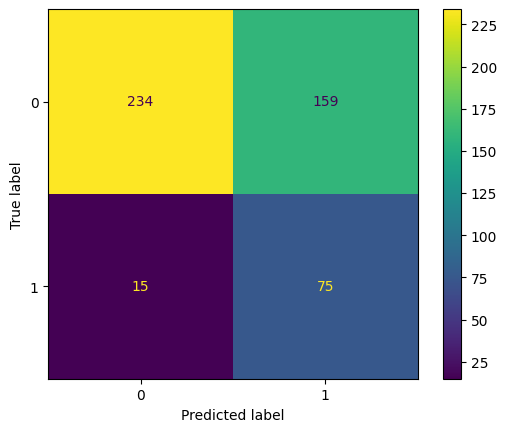


               precision    recall  f1-score   support

           0       0.94      0.60      0.73       393
           1       0.32      0.83      0.46        90

    accuracy                           0.64       483
   macro avg       0.63      0.71      0.60       483
weighted avg       0.82      0.64      0.68       483

Sensitivity: 0.833 Specificity: 0.595 Precision: 0.824 ROC_AUC_SCORE: 0.812



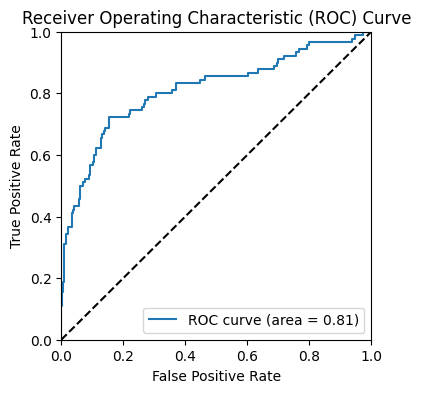

Testing Complete
Test using model 3
483/483 [==============================] - 26s 55ms/step


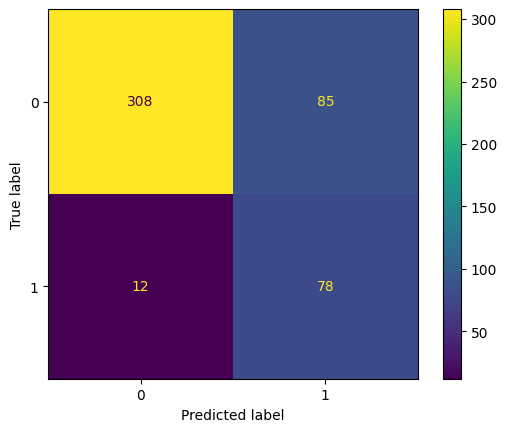


               precision    recall  f1-score   support

           0       0.96      0.78      0.86       393
           1       0.48      0.87      0.62        90

    accuracy                           0.80       483
   macro avg       0.72      0.83      0.74       483
weighted avg       0.87      0.80      0.82       483

Sensitivity: 0.867 Specificity: 0.784 Precision: 0.872 ROC_AUC_SCORE: 0.898



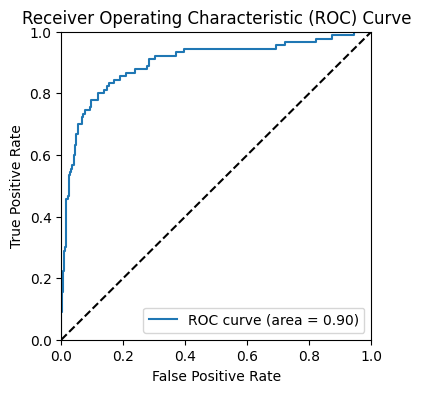

Testing Complete
Test using model 4
483/483 [==============================] - 22s 46ms/step


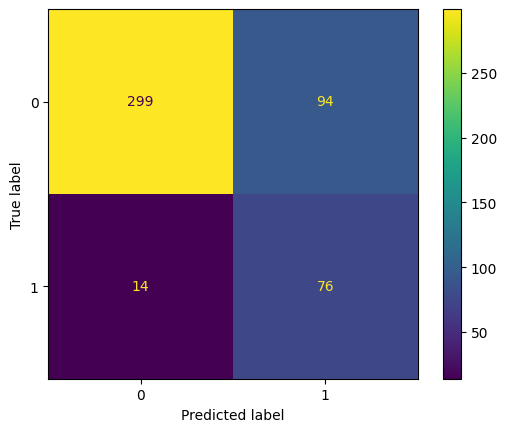


               precision    recall  f1-score   support

           0       0.96      0.76      0.85       393
           1       0.45      0.84      0.58        90

    accuracy                           0.78       483
   macro avg       0.70      0.80      0.72       483
weighted avg       0.86      0.78      0.80       483

Sensitivity: 0.844 Specificity: 0.761 Precision: 0.861 ROC_AUC_SCORE: 0.875



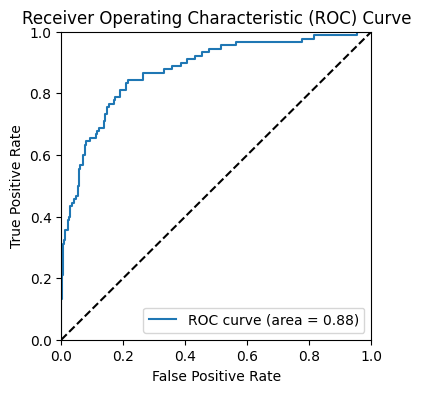

Testing Complete


In [22]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")